# Week3 Assignment

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

/Users/Yubo/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


特征工程就不做了，看了老师的特征工程，直接调用

In [2]:
dpath = "/Users/Yubo/Desktop/AI/CSDN_AI_Eng/csdn_week3/week3_homework/code/data/"
train = pd.read_csv(dpath + 'RentListingInquries_FE_train.csv')
test = pd.read_csv(dpath + 'RentListingInquries_FE_test.csv')

In [3]:
train.head(5)
train.shape

(49352, 228)

In [4]:
#数据太多了，我的小本本跑不起来，弄少点儿调调参
X_train = train.iloc[0:10000,1:227]  # all rows, all the features and no labels
y_train = train.iloc[0:10000, -1]  # all rows, label only

## 1. 直接调用xgboost内嵌的cv寻找最佳的参数n_estimators


In [5]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)
kf=kfold.split(X_train,y_train)


In [38]:
def modelfit(alg, X_train, y_train, cv_folds= None, early_stopping_rounds=10):
    xgb_param = alg.get_xgb_params()
    xgb_param['num_class'] = 3
    
    #直接调用xgboost，而非sklarn的wrapper类
    xgtrain = xgb.DMatrix(X_train, label = y_train)
        
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], folds =cv_folds,
             metrics='mlogloss', early_stopping_rounds=early_stopping_rounds)
  
    cvresult.to_csv('1_nestimators.csv', index_label = 'n_estimators')
    
    #最佳参数n_estimators
    n_estimators = cvresult.shape[0]
    
    # 采用交叉验证得到的最佳参数n_estimators，训练模型
    alg.set_params(n_estimators = n_estimators)
    alg.fit(X_train, y_train, eval_metric='mlogloss')
        
    #Predict training set:
    train_predprob = alg.predict_proba(X_train)
    logloss = metrics.log_loss(y_train, train_predprob)

   #Print model report:
    print ("logloss of train :" )
    print logloss

In [7]:
#params = {"objective": "multi:softprob", "eval_metric":"mlogloss", "num_class": 3}
xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,  #数值大没关系，cv会自动返回合适的n_estimators
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.3,
        colsample_bytree=0.8,
        colsample_bylevel=0.7,
        objective= 'multi:softprob',
        seed=3)

modelfit(xgb1, X_train, y_train, cv_folds = kf)

logloss of train :
0.47327580855


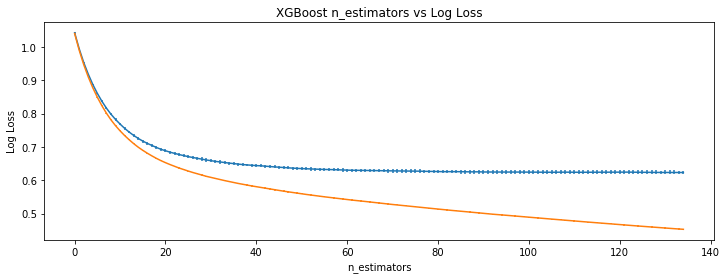

In [8]:
cvresult = pd.DataFrame.from_csv('1_nestimators.csv')
        
# plot
test_means = cvresult['test-mlogloss-mean']
test_stds = cvresult['test-mlogloss-std'] 
        
train_means = cvresult['train-mlogloss-mean']
train_stds = cvresult['train-mlogloss-std'] 

x_axis = range(0, cvresult.shape[0])
        
plt.errorbar(x_axis, test_means, yerr=test_stds ,label='Test')
plt.errorbar(x_axis, train_means, yerr=train_stds ,label='Train')
plt.title("XGBoost n_estimators vs Log Loss")
plt.xlabel( 'n_estimators' )
plt.ylabel( 'Log Loss' )
plt.savefig( 'n_estimators4_1.png' )

plt.show()

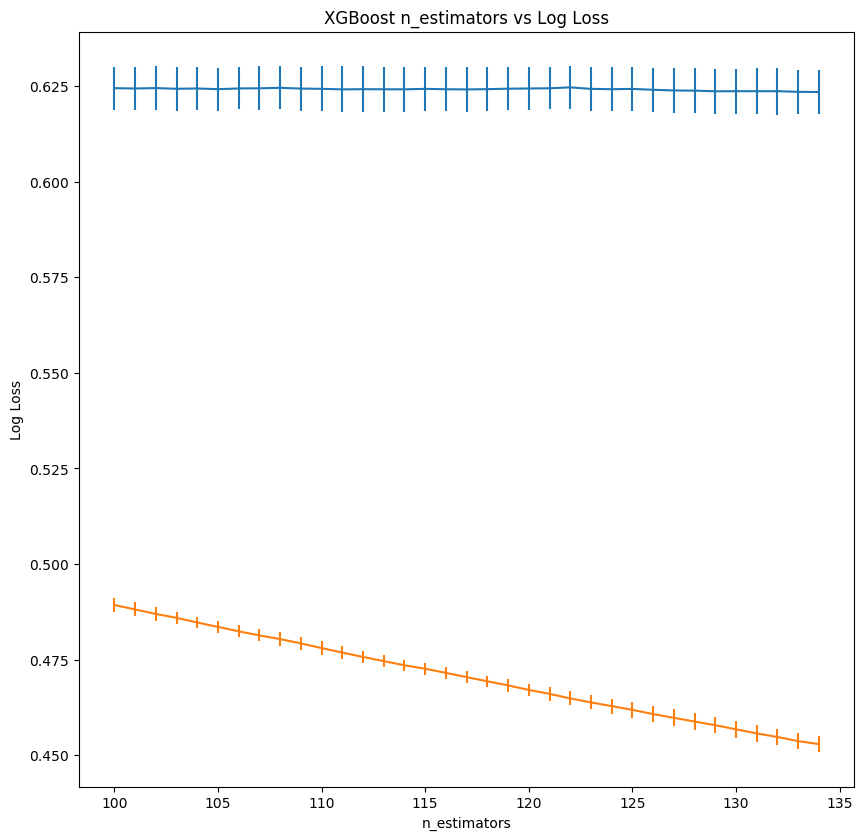

In [9]:
cvresult = pd.DataFrame.from_csv('1_nestimators.csv')

cvresult = cvresult.iloc[100:]
# plot
test_means = cvresult['test-mlogloss-mean']
test_stds = cvresult['test-mlogloss-std'] 
        
train_means = cvresult['train-mlogloss-mean']
train_stds = cvresult['train-mlogloss-std'] 

x_axis = range(100,cvresult.shape[0]+100)
        
fig = plt.figure(figsize=(10, 10), dpi=100)
plt.errorbar(x_axis, test_means, yerr=test_stds ,label='Test')
plt.errorbar(x_axis, train_means, yerr=train_stds ,label='Train')
plt.title("XGBoost n_estimators vs Log Loss")
plt.xlabel( 'n_estimators' )
plt.ylabel( 'Log Loss' )
plt.savefig( 'n_estimators_detail.png' )

plt.show()

# 第二步：调整树的参数：max_depth & min_child_weight

第一轮参数调整得到的n_estimators最优值（106），其余参数继续默认值

In [10]:
#max_depth 建议3-10， min_child_weight=1／sqrt(ratio_rare_event) =5.5
max_depth = range(3,10,2)
min_child_weight = range(1,6,2)
param_test2_1 = dict(max_depth=max_depth, min_child_weight=min_child_weight)
param_test2_1

{'max_depth': [3, 5, 7, 9], 'min_child_weight': [1, 3, 5]}

In [11]:
xgb2_1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=106,  #第一轮参数调整得到的n_estimators最优值
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.3,
        colsample_bytree=0.8,
        colsample_bylevel = 0.7,
        objective= 'multi:softprob',
        seed=3)


gsearch2_1 = GridSearchCV(xgb2_1, param_grid = param_test2_1, scoring='neg_log_loss',n_jobs=-1, cv=kfold)
gsearch2_1.fit(X_train , y_train)

gsearch2_1.grid_scores_, gsearch2_1.best_params_,     gsearch2_1.best_score_

/Users/Yubo/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.63001, std: 0.00579, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: -0.63107, std: 0.00520, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: -0.63102, std: 0.00578, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: -0.62420, std: 0.00966, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: -0.62543, std: 0.00687, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: -0.62650, std: 0.00895, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: -0.63877, std: 0.00927, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: -0.63498, std: 0.01105, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: -0.63072, std: 0.00847, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: -0.64854, std: 0.01043, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: -0.64226, std: 0.01034, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: -0.63606, std: 0.01174, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 5, 'min_chil

In [12]:
gsearch2_1.cv_results_

{'mean_fit_time': array([ 10.40138259,   8.79986119,   8.73853617,  13.84563422,
         13.81859999,  13.82009902,  19.11674123,  18.75843472,
         18.49697223,  23.74951258,  23.36606236,  23.1425683 ]),
 'mean_score_time': array([ 0.05756078,  0.05474725,  0.05671163,  0.07447276,  0.0759306 ,
         0.07562542,  0.09062648,  0.09183912,  0.09054003,  0.11163974,
         0.12681036,  0.09190631]),
 'mean_test_score': array([-0.63001319, -0.63107128, -0.63101936, -0.62419796, -0.62542513,
        -0.62649632, -0.63877321, -0.63498269, -0.63071621, -0.64853876,
        -0.64225889, -0.6360618 ]),
 'mean_train_score': array([-0.58026273, -0.58359528, -0.58556638, -0.48312985, -0.49670262,
        -0.50679301, -0.36541607, -0.4053169 , -0.43244184, -0.26784162,
        -0.33252136, -0.37442056]),
 'param_max_depth': masked_array(data = [3 3 3 5 5 5 7 7 7 9 9 9],
              mask = [False False False False False False False False False False False False],
        fill_value = ?

Best: -0.624198 using {'max_depth': 5, 'min_child_weight': 1}


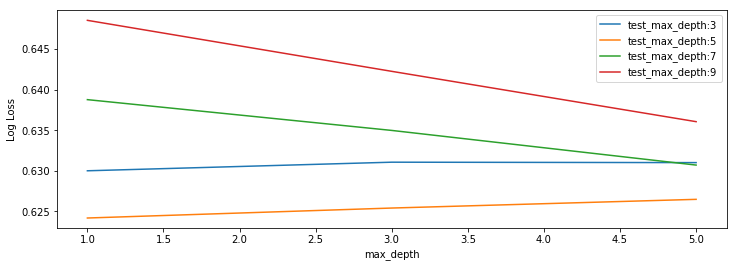

In [13]:
# summarize results
print("Best: %f using %s" % (gsearch2_1.best_score_, gsearch2_1.best_params_))
test_means = gsearch2_1.cv_results_[ 'mean_test_score' ]
test_stds = gsearch2_1.cv_results_[ 'std_test_score' ]
train_means = gsearch2_1.cv_results_[ 'mean_train_score' ]
train_stds = gsearch2_1.cv_results_[ 'std_train_score' ]

pd.DataFrame(gsearch2_1.cv_results_).to_csv('my_preds_maxdepth_min_child_weights_1.csv')

# plot results
test_scores = np.array(test_means).reshape(len(max_depth), len(min_child_weight))
train_scores = np.array(train_means).reshape(len(max_depth), len(min_child_weight))

for i, value in enumerate(max_depth):
    plt.plot(min_child_weight, -test_scores[i], label= 'test_max_depth:'   + str(value))
#for i, value in enumerate(min_child_weight):
#    pyplot.plot(max_depth, train_scores[i], label= 'train_min_child_weight:'   + str(value))
    
plt.legend()
plt.xlabel( 'max_depth' )                                                                                                      
plt.ylabel( 'Log Loss' )
plt.savefig('max_depth_vs_min_child_weght_1.png' )

再次微调

In [14]:
#max_depth 建议3-10， min_child_weight=1／sqrt(ratio_rare_event) =5.5
max_depth = [6,7,8]
min_child_weight = [4,5,6]
param_test2_2 = dict(max_depth=max_depth, min_child_weight=min_child_weight)
param_test2_2

{'max_depth': [6, 7, 8], 'min_child_weight': [4, 5, 6]}

In [15]:
xgb2_2 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=106,  #第一轮参数调整得到的n_estimators最优值
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.3,
        colsample_bytree=0.8,
        colsample_bylevel = 0.7,
        objective= 'multi:softprob',
        seed=3)


gsearch2_2 = GridSearchCV(xgb2_2, param_grid = param_test2_2, scoring='neg_log_loss',n_jobs=-1, cv=kfold)
gsearch2_2.fit(X_train , y_train)

gsearch2_2.grid_scores_, gsearch2_2.best_params_,     gsearch2_2.best_score_

/Users/Yubo/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.62786, std: 0.00913, params: {'max_depth': 6, 'min_child_weight': 4},
  mean: -0.62674, std: 0.00961, params: {'max_depth': 6, 'min_child_weight': 5},
  mean: -0.62595, std: 0.01102, params: {'max_depth': 6, 'min_child_weight': 6},
  mean: -0.63233, std: 0.01028, params: {'max_depth': 7, 'min_child_weight': 4},
  mean: -0.63072, std: 0.00847, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: -0.63047, std: 0.00872, params: {'max_depth': 7, 'min_child_weight': 6},
  mean: -0.63639, std: 0.00736, params: {'max_depth': 8, 'min_child_weight': 4},
  mean: -0.63423, std: 0.00971, params: {'max_depth': 8, 'min_child_weight': 5},
  mean: -0.63571, std: 0.00974, params: {'max_depth': 8, 'min_child_weight': 6}],
 {'max_depth': 6, 'min_child_weight': 6},
 -0.62595254119471644)

In [16]:
gsearch2_2.cv_results_

{'mean_fit_time': array([ 21.12147708,  20.40395732,  18.95859041,  20.94686155,
         18.85391841,  18.45414219,  20.85379653,  20.69624696,  19.08767056]),
 'mean_score_time': array([ 0.099686  ,  0.08939242,  0.08597083,  0.09455543,  0.09019556,
         0.09332838,  0.0989285 ,  0.09545374,  0.08490438]),
 'mean_test_score': array([-0.62786164, -0.62673694, -0.62595254, -0.63233127, -0.63071621,
        -0.63046748, -0.63638843, -0.63422605, -0.63571068]),
 'mean_train_score': array([-0.45985549, -0.46736168, -0.47575992, -0.42011949, -0.43244184,
        -0.44296075, -0.38290501, -0.39892215, -0.41360291]),
 'param_max_depth': masked_array(data = [6 6 6 7 7 7 8 8 8],
              mask = [False False False False False False False False False],
        fill_value = ?),
 'param_min_child_weight': masked_array(data = [4 5 6 4 5 6 4 5 6],
              mask = [False False False False False False False False False],
        fill_value = ?),
 'params': ({'max_depth': 6, 'min_child_w

Best: -0.625953 using {'max_depth': 6, 'min_child_weight': 6}


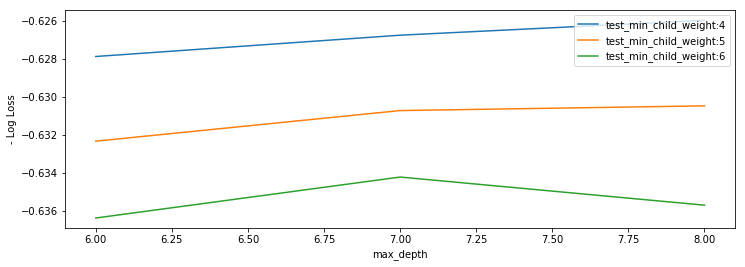

In [17]:
# summarize results
print("Best: %f using %s" % (gsearch2_2.best_score_, gsearch2_2.best_params_))
test_means = gsearch2_2.cv_results_[ 'mean_test_score' ]
test_stds = gsearch2_2.cv_results_[ 'std_test_score' ]
train_means = gsearch2_2.cv_results_[ 'mean_train_score' ]
train_stds = gsearch2_2.cv_results_[ 'std_train_score' ]

pd.DataFrame(gsearch2_2.cv_results_).to_csv('my_preds_maxdepth_min_child_weights_2.csv')

# plot results
test_scores = np.array(test_means).reshape(len(min_child_weight), len(max_depth))
train_scores = np.array(train_means).reshape(len(min_child_weight), len(max_depth))

for i, value in enumerate(min_child_weight):
    plt.plot(max_depth, test_scores[i], label= 'test_min_child_weight:'   + str(value))
#for i, value in enumerate(min_child_weight):
#    pyplot.plot(max_depth, train_scores[i], label= 'train_min_child_weight:'   + str(value))
    
plt.legend()
plt.xlabel( 'max_depth' )                                                                                                      
plt.ylabel( '- Log Loss' )
plt.savefig( 'max_depth_vs_min_child_weght2.png' )

## 第三步 再次调整nestimators

In [42]:
def modelfit(alg, X_train, y_train, useTrainCV=True, cv_folds=None, early_stopping_rounds=100):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgb_param['num_class'] = 3
        
        xgtrain = xgb.DMatrix(X_train, label = y_train)
        
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], folds =cv_folds,
                         metrics='mlogloss', early_stopping_rounds=early_stopping_rounds)
        
        n_estimators = cvresult.shape[0]
        alg.set_params(n_estimators = n_estimators)
        
        print cvresult
        #result = pd.DataFrame(cvresult)   #cv缺省返回结果为DataFrame
        #result.to_csv('my_preds.csv', index_label = 'n_estimators')
        cvresult.to_csv('my_preds4_2_3_106.csv', index_label = 'n_estimators')
        
        # plot
        test_means = cvresult['test-mlogloss-mean']
        test_stds = cvresult['test-mlogloss-std'] 
        
        train_means = cvresult['train-mlogloss-mean']
        train_stds = cvresult['train-mlogloss-std'] 

        x_axis = range(0, n_estimators)
        plt.errorbar(x_axis, test_means, yerr=test_stds ,label='Test')
        plt.errorbar(x_axis, train_means, yerr=train_stds ,label='Train')
        plt.title("XGBoost n_estimators vs Log Loss")
        plt.xlabel( 'n_estimators' )
        plt.ylabel( 'Log Loss' )
        plt.savefig( 'n_estimators4_2_3_106.png' )
    
    #Fit the algorithm on the data
    alg.fit(X_train, y_train, eval_metric='mlogloss')
        
    #Predict training set:
    train_predprob = alg.predict_proba(X_train)
    logloss = log_loss(y_train, train_predprob)

        
    #Print model report:
    print ("logloss of train :" )
    print logloss

In [43]:
#调整max_depth和min_child_weight之后再次调整n_estimators(6,4)
xgb2_3 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=106,  #数值大没关系，cv会自动返回合适的n_estimators
        max_depth=6,
        min_child_weight=6,
        gamma=0,
        subsample=0.3,
        colsample_bytree=0.8,
        colsample_bylevel=0.7,
        objective= 'multi:softprob',
        seed=3)

modelfit(xgb2_3, X_train, y_train, cv_folds = kf)
#from sklearn.model_selection import cross_val_score
#results = cross_val_score(xgb2_3, X_train, y_train, metrics='mlogloss', cv=kfold)
#print results
#print("CV logloss: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

IndexError: list index out of range

不知道为什么总是报INDEX的错， 求帮助解答一下

### 第四步：调整树的参数：subsample 和 colsample_bytree
(粗调，参数的步长为0.1；下一步是在粗调最佳参数周围，将步长降为0.05，进行精细调整)

In [44]:
#max_depth 建议3-10， min_child_weight=1／sqrt(ratio_rare_event) =5.5
subsample = [i/10.0 for i in range(3,9)]
colsample_bytree = [i/10.0 for i in range(6,10)]
param_test3_1 = dict(subsample=subsample, colsample_bytree=colsample_bytree)
param_test3_1



{'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
 'subsample': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]}

In [50]:
xgb3_1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=106,  #第二轮参数调整得到的n_estimators最优值，第二轮报错，不知道为啥继续用第一轮的吧。。
        max_depth=6,
        min_child_weight=6,
        gamma=0,
        subsample=0.3,
        colsample_bytree=0.8,
        colsample_bylevel = 0.7,
        objective= 'multi:softprob',
        seed=3)


gsearch3_1 = GridSearchCV(xgb3_1, param_grid = param_test3_1, scoring='neg_log_loss',n_jobs=-1, cv=kfold)
gsearch3_1.fit(X_train , y_train)

gsearch3_1.grid_scores_, gsearch3_1.best_params_,     gsearch3_1.best_score_

/Users/Yubo/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.62607, std: 0.00903, params: {'subsample': 0.3, 'colsample_bytree': 0.6},
  mean: -0.62408, std: 0.00915, params: {'subsample': 0.4, 'colsample_bytree': 0.6},
  mean: -0.62205, std: 0.00859, params: {'subsample': 0.5, 'colsample_bytree': 0.6},
  mean: -0.61969, std: 0.01048, params: {'subsample': 0.6, 'colsample_bytree': 0.6},
  mean: -0.61855, std: 0.01087, params: {'subsample': 0.7, 'colsample_bytree': 0.6},
  mean: -0.61906, std: 0.01031, params: {'subsample': 0.8, 'colsample_bytree': 0.6},
  mean: -0.62792, std: 0.00954, params: {'subsample': 0.3, 'colsample_bytree': 0.7},
  mean: -0.62443, std: 0.00747, params: {'subsample': 0.4, 'colsample_bytree': 0.7},
  mean: -0.62116, std: 0.00923, params: {'subsample': 0.5, 'colsample_bytree': 0.7},
  mean: -0.61832, std: 0.00819, params: {'subsample': 0.6, 'colsample_bytree': 0.7},
  mean: -0.61892, std: 0.00983, params: {'subsample': 0.7, 'colsample_bytree': 0.7},
  mean: -0.61866, std: 0.00885, params: {'subsample': 0.8, 'colsa

In [51]:
gsearch3_1.cv_results_

{'mean_fit_time': array([ 14.18745112,  15.01321921,  16.45907474,  16.28776875,
         15.67321739,  15.44479666,  14.69118161,  16.96318936,
         18.59073029,  18.63828301,  18.10248837,  17.41086264,
         16.5257072 ,  21.7342092 ,  23.7305944 ,  21.90365973,
         20.57450233,  19.90708723,  18.332621  ,  21.233248  ,
         23.41412997,  23.45283422,  22.71515808,  21.33621559]),
 'mean_score_time': array([ 0.08577032,  0.08900876,  0.08252521,  0.0800107 ,  0.07926903,
         0.08520236,  0.08351603,  0.08127737,  0.08348312,  0.08440976,
         0.08105245,  0.07947998,  0.0827816 ,  0.11370196,  0.08775816,
         0.10140262,  0.07993579,  0.0795814 ,  0.08339357,  0.08204498,
         0.08195205,  0.08030753,  0.08052473,  0.07913399]),
 'mean_test_score': array([-0.62607192, -0.62407577, -0.62205033, -0.61968935, -0.61854797,
        -0.61905692, -0.62791773, -0.62443426, -0.62115878, -0.61832082,
        -0.61892154, -0.61866031, -0.62595254, -0.62386331,

Best: -0.617174 using {'subsample': 0.8, 'colsample_bytree': 0.8}


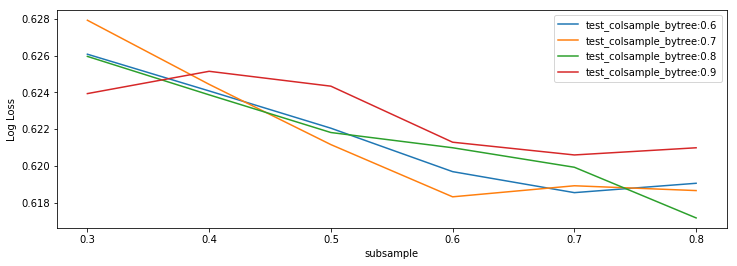

In [52]:
# summarize results
print("Best: %f using %s" % (gsearch3_1.best_score_, gsearch3_1.best_params_))
test_means = gsearch3_1.cv_results_[ 'mean_test_score' ]
test_stds = gsearch3_1.cv_results_[ 'std_test_score' ]
train_means = gsearch3_1.cv_results_[ 'mean_train_score' ]
train_stds = gsearch3_1.cv_results_[ 'std_train_score' ]

pd.DataFrame(gsearch3_1.cv_results_).to_csv('my_preds_subsampleh_colsample_bytree_1.csv')

# plot results
test_scores = np.array(test_means).reshape(len(colsample_bytree), len(subsample))
train_scores = np.array(train_means).reshape(len(colsample_bytree), len(subsample))

for i, value in enumerate(colsample_bytree):
    plt.plot(subsample, -test_scores[i], label= 'test_colsample_bytree:'   + str(value))
#for i, value in enumerate(min_child_weight):
#    pyplot.plot(max_depth, train_scores[i], label= 'train_min_child_weight:'   + str(value))
    
plt.legend()
plt.xlabel( 'subsample' )                                                                                                      
plt.ylabel( 'Log Loss' )
plt.savefig( 'subsample_vs_colsample_bytree1.png' )

怎么越调越低了- -

## 第五步 调整正则化参数：reg_alpha 和reg_lambda

In [53]:
#reg_alpha = [1e-3, 1e-2, 0.05, 0.1]    #default = 0
#reg_lambda = [1e-3, 1e-2, 0.05, 0.1]   #default = 1

reg_alpha = [ 1.5, 2]    #default = 0, 测试0.1,1，1.5，2
reg_lambda = [0.5, 1, 2]      #default = 1，测试0.1， 0.5， 1，2

param_test5_1 = dict(reg_alpha=reg_alpha, reg_lambda=reg_lambda)
param_test5_1



{'reg_alpha': [1.5, 2], 'reg_lambda': [0.5, 1, 2]}

In [54]:
xgb5_1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=106,  #第二轮参数调整得到的n_estimators最优值
        max_depth=6,
        min_child_weight=6,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        colsample_bylevel = 0.7,
        objective= 'multi:softprob',
        seed=3)


gsearch5_1 = GridSearchCV(xgb5_1, param_grid = param_test5_1, scoring='neg_log_loss',n_jobs=-1, cv=kfold)
gsearch5_1.fit(X_train , y_train)

gsearch5_1.grid_scores_, gsearch5_1.best_params_,     gsearch5_1.best_score_

/Users/Yubo/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.61830, std: 0.00993, params: {'reg_alpha': 1.5, 'reg_lambda': 0.5},
  mean: -0.61861, std: 0.01057, params: {'reg_alpha': 1.5, 'reg_lambda': 1},
  mean: -0.61918, std: 0.01035, params: {'reg_alpha': 1.5, 'reg_lambda': 2},
  mean: -0.61869, std: 0.00989, params: {'reg_alpha': 2, 'reg_lambda': 0.5},
  mean: -0.61925, std: 0.00962, params: {'reg_alpha': 2, 'reg_lambda': 1},
  mean: -0.61882, std: 0.01074, params: {'reg_alpha': 2, 'reg_lambda': 2}],
 {'reg_alpha': 1.5, 'reg_lambda': 0.5},
 -0.61829663433644455)

In [55]:
gsearch5_1.cv_results_

{'mean_fit_time': array([ 20.12935028,  19.89325128,  19.92527461,  19.90518579,
         19.8822525 ,  16.92397175]),
 'mean_score_time': array([ 0.08821359,  0.08598223,  0.08885431,  0.08353925,  0.08335509,
         0.07835526]),
 'mean_test_score': array([-0.61829663, -0.61860876, -0.61918026, -0.61869174, -0.61925132,
        -0.61881626]),
 'mean_train_score': array([-0.44407397, -0.44654429, -0.45149558, -0.44996169, -0.45236472,
        -0.45665784]),
 'param_reg_alpha': masked_array(data = [1.5 1.5 1.5 2 2 2],
              mask = [False False False False False False],
        fill_value = ?),
 'param_reg_lambda': masked_array(data = [0.5 1 2 0.5 1 2],
              mask = [False False False False False False],
        fill_value = ?),
 'params': ({'reg_alpha': 1.5, 'reg_lambda': 0.5},
  {'reg_alpha': 1.5, 'reg_lambda': 1},
  {'reg_alpha': 1.5, 'reg_lambda': 2},
  {'reg_alpha': 2, 'reg_lambda': 0.5},
  {'reg_alpha': 2, 'reg_lambda': 1},
  {'reg_alpha': 2, 'reg_lambda': 2}),
 

Best: -0.618297 using {'reg_alpha': 1.5, 'reg_lambda': 0.5}


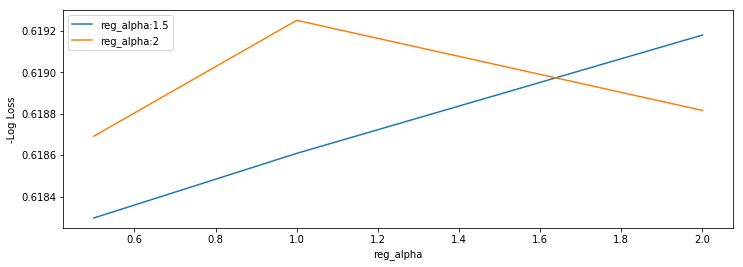

In [57]:
# summarize results
print("Best: %f using %s" % (gsearch5_1.best_score_, gsearch5_1.best_params_))
test_means = gsearch5_1.cv_results_[ 'mean_test_score' ]
test_stds = gsearch5_1.cv_results_[ 'std_test_score' ]
train_means = gsearch5_1.cv_results_[ 'mean_train_score' ]
train_stds = gsearch5_1.cv_results_[ 'std_train_score' ]

pd.DataFrame(gsearch5_1.cv_results_).to_csv('my_preds_reg_alpha_reg_lambda_1.csv')

# plot results
test_scores = np.array(test_means).reshape(len(reg_alpha), len(reg_lambda))
train_scores = np.array(train_means).reshape(len(reg_alpha), len(reg_lambda))

#log_reg_alpha = [0,0,0,0]
#for index in range(len(reg_alpha)):
#   log_reg_alpha[index] = math.log10(reg_alpha[index])
    
for i, value in enumerate(reg_alpha):
    plt.plot(reg_lambda, -test_scores[i], label= 'reg_alpha:'   + str(value))
#for i, value in enumerate(min_child_weight):
#    pyplot.plot(max_depth, train_scores[i], label= 'train_min_child_weight:'   + str(value))
    
plt.legend()
plt.xlabel( 'reg_alpha' )                                                                                                      
plt.ylabel( '-Log Loss' )
plt.savefig( 'reg_alpha_vs_reg_lambda1.png' )